In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision.transforms as transforms
# import torchvision.datasets as datasets
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from norse.torch.module.lif import LIFCell
import matplotlib.pyplot as plt
import encoder

In [152]:
class RestrictedRateEncoder(torch.nn.Module):
    def __init__(self, time_window, fire_window_ratio):
        super(RestrictedRateEncoder, self).__init__()
        self.time_window = time_window
        self.fire_window = int(time_window * fire_window_ratio)

    def forward(self, x):
        batch_size, _, height, width = x.shape
        spikes = torch.zeros(batch_size, height, width, self.time_window).to(x.device)

        gray = to_grayscale(x)
        max_latency = 100
        # div = calculate_divergence(x)
        var = calculate_variance(x)
        # plt.imshow(var.reshape(28, 28), cmap='gray')
        # latency = calculate_latency(div, max_latency)
        latency = calculate_latency(var, max_latency)

        for t in range(self.time_window):
            firing_mask = ((t >= latency) & (t < latency + self.fire_window)).float()
            spike_prob = torch.rand(batch_size, height, width).to(x.device)
            spikes[:, :, :, t] = (spike_prob < gray.squeeze(1)) * firing_mask

        return spikes

def to_grayscale(image):
    return torch.mean(image, dim=1, keepdim=True)

def calculate_divergence(image, kernels=[5, 11, 15]):
    # kernels = [5, 11, 15]
    div_images = []

    for kernel_size in kernels:
        div = F.avg_pool2d(image.float(), kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        div_images.append(div)

    div_avg = sum(div_images) / len(kernels)
    div_avg = to_grayscale(div_avg)
    
    return div_avg

def calculate_variance(image, kernels=[5, 11, 15]):
    kernels = [5]
    variance_images = []

    # for kernel_size in kernels:
        # pooled_image = F.avg_pool2d(image.float(), kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
    #     variance = F.avg_pool2d((image.float() - pooled_image) ** 2, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
    #     variance_images.append(variance)

    for kernel_size in kernels:
        print(image.shape)
        padded_image = F.pad(image.float(), (kernel_size//2, kernel_size//2, kernel_size//2, kernel_size//2), mode='constant')/255
        print(padded_image.shape)
        pooled_image = F.avg_pool2d(padded_image, kernel_size=kernel_size, stride=1, padding=0)
        print(pooled_image.shape)
        # plt.imshow(padded_image.reshape(32, 32, 3))
        # plt.imshow(pooled_image.reshape(28, 28, 3))
        # plt.figure(figsize=(10, 5))
        # plt.subplot(1, 2, 1)
        # plt.title(f"Padded Image (Kernel={kernel_size})")
        # plt.imshow(padded_image[0][0].cpu().detach().numpy())

        # plt.subplot(1, 2, 2)
        # plt.title(f"Pooled Image (Kernel={kernel_size})")
        # plt.imshow(pooled_image[0][0].cpu().detach().numpy())
        # plt.show()
        # variance = F.avg_pool2d((image - pooled_image) ** 2, kernel_size=kernel_size, stride=1, padding=0)
        # variance_images.append(variance[:, :, kernel_size//2:-kernel_size//2, kernel_size//2:-kernel_size//2])
        variance = (image/255 - pooled_image) ** 2
        # plt.imshow(variance.reshape(28, 28, 3))
        variance_images.append(variance)
        print("_______")

    variance_avg = sum(variance_images) / len(kernels)
    plt.imshow(variance_avg.reshape(28, 28, 3))
    print("var_avg shape: ", variance_avg.shape)
    variance_avg = to_grayscale(variance_avg)
    print("var_avg shape: ", variance_avg.shape)
    # temp = variance_avg.squeeze()
    # plt.imshow(temp)
    # print("temp shape:", temp.shape)

    print(variance_avg)
    
    return variance_avg

def calculate_latency(div_image, max_latency):
    min_div, max_div = div_image.min(), div_image.max()
    normalized_div = (div_image - min_div) / (max_div - min_div)
    latency = max_latency * (1 - normalized_div)
    return latency

In [153]:
x.shape

torch.Size([1, 3, 28, 28])

torch.Size([1, 3, 28, 28])
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 28, 28])
_______
var_avg shape:  torch.Size([1, 3, 28, 28])
var_avg shape:  torch.Size([1, 1, 28, 28])
tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00],
          [6.2081e-05, 4.8432e-04, 1.5449e-03, 1.9773e-03, 4.0882e-03,
           5.3415e-03, 3.8038e-03, 2.2435e-03, 2.4183e-03, 1.2732e-03,
           4.1522e-04, 1.1596e-03, 1.9293e-03, 3.0320e-03, 4.2874e-03,
           5.1708e-03, 3.1834e-03, 2.9429e-03, 3.3386e-03, 2.5173e-03,
           2.2521e-03, 3.4440e-03, 4.4672e-03, 4.6013e-03, 3.4867e-03,
           2.8745e-03, 1.7205e-03, 5.1262e-04],
          [6.2081e-

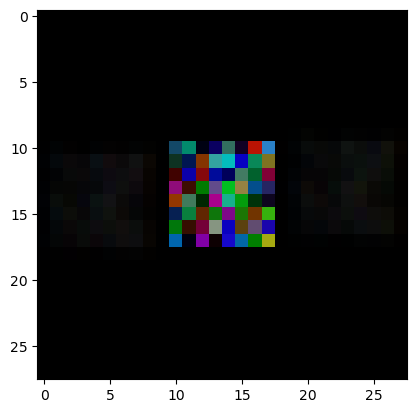

In [154]:
import cv2
import matplotlib.pyplot as plt

# x = cv2.imread("./apple_color.png")
x = cv2.imread("./local_var.png")
x = torch.from_numpy(x.reshape(1, 3, 28, 28).astype(float))

time_window = 100
fire_window_ratio = 0.2

encoder = RestrictedRateEncoder(time_window, fire_window_ratio)
spike_trains = encoder(x)

In [66]:
# cv2.imwrite("local_var.png", image)

True

In [7]:
print(x)

tensor([[[[210., 210., 255.,  ..., 148., 255., 148.],
          [148., 255., 148.,  ..., 255., 148., 148.],
          [255., 148., 148.,  ..., 210., 210., 255.],
          ...,
          [  0., 255.,   0.,  ..., 255.,   0.,   0.],
          [255.,   0.,   0.,  ..., 148., 148., 255.],
          [148., 148., 255.,  ...,   0., 255.,   0.]],

         [[  0., 255.,   0.,  ..., 255.,   0.,   0.],
          [255.,   0.,   0.,  ..., 148., 148., 255.],
          [148., 148., 255.,  ...,   0., 255.,   0.],
          ...,
          [246.,  95.,   0.,  ..., 255., 148., 148.],
          [255., 148., 148.,  ...,   0.,   0., 255.],
          [  0.,   0.,  86.,  ..., 246.,  95.,   0.]],

         [[160., 255.,   0.,  ..., 255., 148., 148.],
          [255., 148., 148.,  ...,   0.,   0., 255.],
          [  0.,   0., 255.,  ..., 160., 255.,   0.],
          ...,
          [255., 210., 210.,  ..., 148., 148., 255.],
          [148., 148., 255.,  ..., 148., 255., 148.],
          [148., 255., 148.,  ...

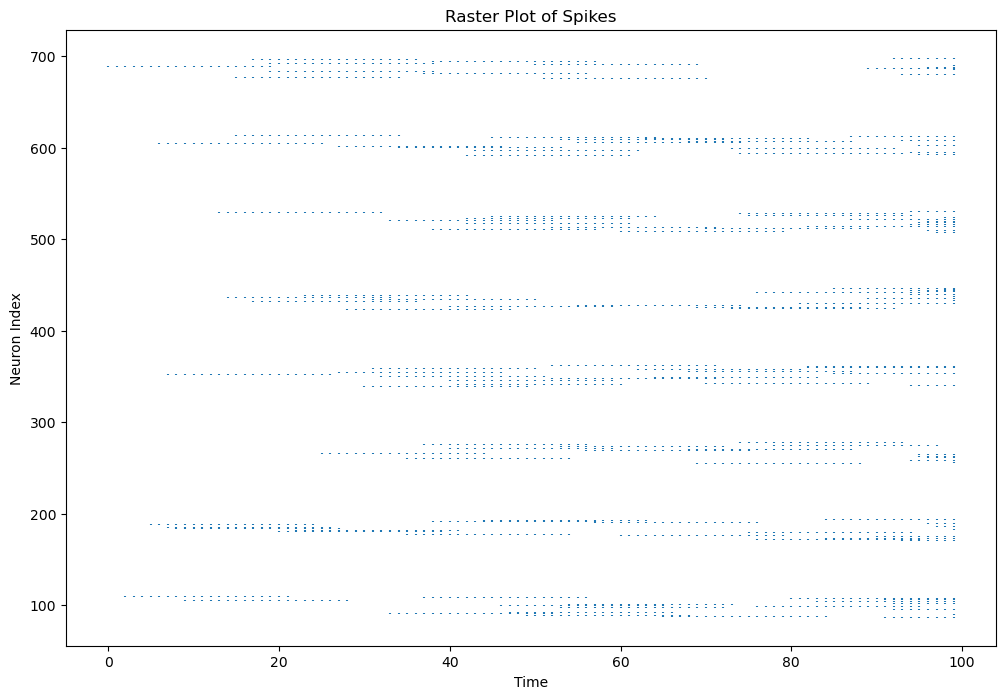

In [151]:
def plot_raster(spike_trains, num_neurons=28):
    spike_trains = spike_trains.cpu().numpy()
    plt.figure(figsize=(12, 8))
    
    for neuron_idx in range(num_neurons):
        neuron_spikes = spike_trains[0, neuron_idx // 28, neuron_idx % 28]
        spike_times = neuron_spikes.nonzero()[0]
        plt.vlines(spike_times, neuron_idx + 0.5, neuron_idx + 1.5)
    
    plt.xlabel('Time')
    plt.ylabel('Neuron Index')
    plt.title('Raster Plot of Spikes')
    plt.show()

plot_raster(spike_trains, num_neurons=28*28)